In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # or any {'0', '1', '2'}
import psutil
from glob import glob
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

import external as ext

# print("="*40, "CPU Info", "="*40)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))

# tf.test.gpu_device_name()

os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.test.gpu_device_name()

2022-10-01 22:31:33.233037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 22:31:33.671597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 22:31:33.671635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 22:31:33.744592: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 22:31:34.979948: W tensorflow/stream_executor/platform/de

In [2]:
BATCH_SIZE = 64
DIM = (128,128)
EPOCHS = 250
NUM_AUGMENTATIONS = 11
SHUFFLE_SEED = 6

In [3]:
dirs = glob("./raw_data/*")
scaler = MinMaxScaler()

augment_raw_audio = Compose(
        [
            AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.025, p=0.75),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.75),
            # HighPassFilter(min_cutoff_freq=2000, max_cutoff_freq=4000, p=0.25)
        ]
    )
'''
    Create spectrograms as tensors - equal number of files (160) per class
'''
x_values = []
y_values = []
for i in tqdm(range(len(glob(os.path.join("raw_data/airplane/", "*"))))):
    for dir in dirs:
        file = glob(os.path.join(dir, "*"))[i]
        spectros, label = ext.build_spectrograms(
            audio_binary = str(file),
            force_sr = 16000
        ).decode_augment_audio(
            augmenter = augment_raw_audio,
            num_augmentations = NUM_AUGMENTATIONS
        ).get_spectrograms(final_dim = DIM)
        
        for spectro in spectros:
        # Transform values between 0 and 1
            spectro = scaler.fit_transform(spectro)
            # Add additional dimension to act as image array
            spectro = spectro[..., tf.newaxis]

            # ext.plot_spectrogram(spectro)
            x_values.append(spectro)
            y_values.append(label)

print(len(x_values))
x_values = np.array(x_values)
x_values = tf.convert_to_tensor(x_values, dtype=tf.float32)
x_values = tf.random.shuffle(x_values, seed=SHUFFLE_SEED)

y_values = np.array(y_values)
INDICES = {}
for i, element in enumerate(np.unique(y_values)):
    INDICES[element] = i
for i in range(len(y_values)):
    label = y_values[i]
    value = INDICES[label]
    y_values[i] = value
y_values = tf.convert_to_tensor(y_values, dtype=tf.int32)
y_values = tf.random.shuffle(y_values, seed=SHUFFLE_SEED)


dataset = tf.data.Dataset.from_tensor_slices(
    (x_values, y_values)).batch(BATCH_SIZE, drop_remainder=True)

NUM_OUTPUTS = len(np.unique(np.concatenate([y for x, y in dataset], axis=0)))

print(INDICES)
print(f'Number of outputs {NUM_OUTPUTS}')

for element in dataset.take(1):
    SHAPE = element[0].shape

  0%|          | 0/40 [00:00<?, ?it/s]2022-10-01 19:45:06.876750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79120 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:12:00.0, compute capability: 8.0
2022-10-01 19:45:09.298863: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 40/40 [33:33<00:00, 50.33s/it]


24000
{'airplane': 0, 'breathing': 1, 'brushing_teeth': 2, 'can_opening': 3, 'car_horn': 4, 'cat': 5, 'chainsaw': 6, 'chirping_birds': 7, 'church_bells': 8, 'clapping': 9, 'clock_alarm': 10, 'clock_tick': 11, 'coughing': 12, 'cow': 13, 'crackling_fire': 14, 'crickets': 15, 'crow': 16, 'crying_baby': 17, 'dog': 18, 'door_wood_creaks': 19, 'door_wood_knock': 20, 'drinking_sipping': 21, 'engine': 22, 'fireworks': 23, 'footsteps': 24, 'frog': 25, 'glass_breaking': 26, 'hand_saw': 27, 'helicopter': 28, 'hen': 29, 'insects': 30, 'keyboard_typing': 31, 'laughing': 32, 'mouse_click': 33, 'pig': 34, 'pouring_water': 35, 'rain': 36, 'rooster': 37, 'sea_waves': 38, 'sheep': 39, 'siren': 40, 'sneezing': 41, 'snoring': 42, 'thunderstorm': 43, 'toilet_flush': 44, 'train': 45, 'vacuum_cleaner': 46, 'washing_machine': 47, 'water_drops': 48, 'wind': 49}
Number of outputs 50


In [4]:
model = ext.customModel(
    set_width=SHAPE[1],
    set_height=SHAPE[2],
    set_colour_depth=SHAPE[3]
).buildModel(num_outputs=NUM_OUTPUTS).compileModel(
    optimiser = "Nadam", loss_metric = SparseCategoricalCrossentropy(
        from_logits=False))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       1

In [5]:
SPLIT_POINT = int(len(dataset) * 0.8)
train_ds = dataset.take(SPLIT_POINT)
remainder = dataset.skip(SPLIT_POINT)

SPLIT_POINT = int(len(remainder) * 0.5)
val_ds = remainder.take(SPLIT_POINT)
test_ds = remainder.take(SPLIT_POINT)

print(len(train_ds),len(val_ds),len(test_ds),)

300 37 37


In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience = 15, verbose=1),
    ModelCheckpoint(
        './chk_mdl_wts.hdf5',
        save_best_only=True,
        monitor='val_Accuracy',
        mode='max'
      ),
    # ReduceLROnPlateau(factor = 0.1, patience = 8)
]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    callbacks=callbacks
)
model.load_weights("./chk_mdl_wts.hdf5")

ext.save_model(model_in=model, save_dir="./saved_models", save_name="Multi-Class_AudioRecognition")

Epoch 1/250


2022-10-01 20:18:47.196328: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


300/300 [==============================] - 21s 49ms/step - loss: 3.6369 - Accuracy: 0.0945 - val_loss: 8.8514 - val_Accuracy: 0.0190
Epoch 2/250
300/300 [==============================] - 14s 46ms/step - loss: 2.4005 - Accuracy: 0.3361 - val_loss: 4.4092 - val_Accuracy: 0.1677
Epoch 3/250
300/300 [==============================] - 14s 46ms/step - loss: 1.3826 - Accuracy: 0.5978 - val_loss: 1.6437 - val_Accuracy: 0.5891
Epoch 4/250
300/300 [==============================] - 14s 46ms/step - loss: 0.7692 - Accuracy: 0.7690 - val_loss: 0.8517 - val_Accuracy: 0.7732
Epoch 5/250
300/300 [==============================] - 14s 47ms/step - loss: 0.5028 - Accuracy: 0.8495 - val_loss: 0.4635 - val_Accuracy: 0.8682
Epoch 6/250
300/300 [==============================] - 14s 47ms/step - loss: 0.3467 - Accuracy: 0.8982 - val_loss: 0.7450 - val_Accuracy: 0.8311
Epoch 7/250
300/300 [==============================] - 15s 48ms/step - loss: 0.2725 - Accuracy: 0.9194 - val_loss: 0.4034 - val_Accuracy: 0.89

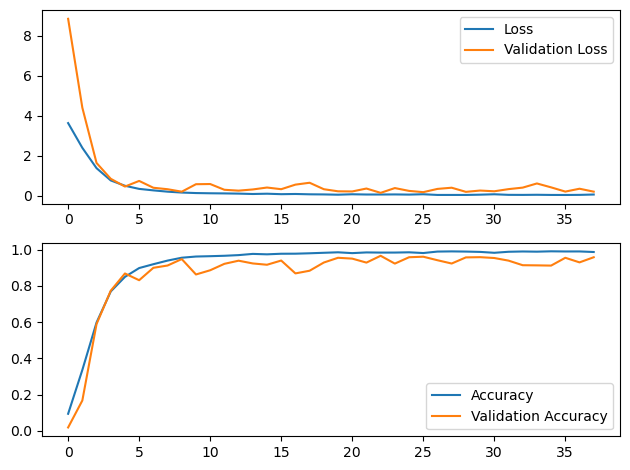

In [7]:
ext.visualise_performance (history)

37/37 [==============================] - 1s 12ms/step


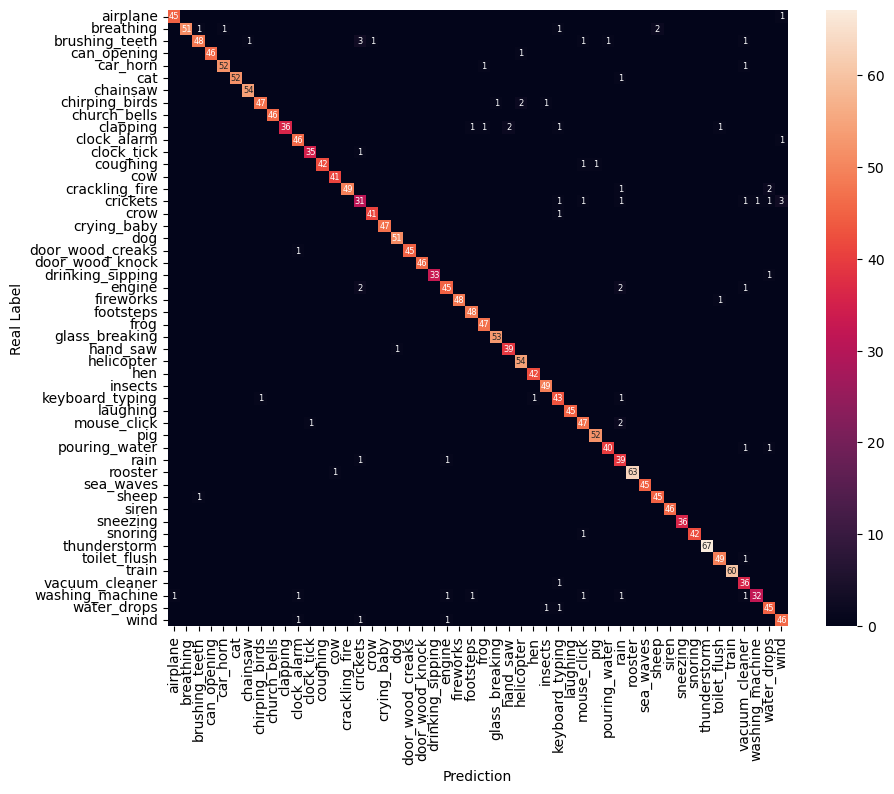

In [8]:
ext.model_accuracy(model, test_ds, INDICES)